In [ ]:
# =============================================================================
# COMPLETE DREAMBOOTH BOOK COVER TRAINING - GOOGLE COLAB
# =============================================================================

# Check GPU
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

GPU Available: True
GPU Name: Tesla T4


In [ ]:
# =============================================================================
# STEP 1: Installation and Setup
# =============================================================================


Found existing installation: diffusers 0.30.2
Uninstalling diffusers-0.30.2:
  Successfully uninstalled diffusers-0.30.2
Found existing installation: transformers 4.44.2
Uninstalling transformers-4.44.2:
  Successfully uninstalled transformers-4.44.2
Found existing installation: accelerate 0.33.0
Uninstalling accelerate-0.33.0:
  Successfully uninstalled accelerate-0.33.0
Found existing installation: huggingface-hub 0.24.5
Uninstalling huggingface-hub-0.24.5:
  Successfully uninstalled huggingface-hub-0.24.5
Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: sentence-transformers 3.0.1
Uninstalling sentence

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 kB 41.9 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


In [1]:
# Remove problematic packages
!pip uninstall -y diffusers transformers accelerate huggingface_hub torch torchvision torchaudio sentence-transformers xformers bitsandbytes safetensors

# Install PyTorch + matching xformers for CUDA 12.4
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install xformers --index-url https://download.pytorch.org/whl/cu124

# Install Hugging Face stack
!pip install diffusers==0.30.0 transformers==4.42.4 sentence-transformers==3.0.1 accelerate==0.33.0 huggingface_hub==0.24.5 bitsandbytes safetensors


Found existing installation: diffusers 0.34.0
Uninstalling diffusers-0.34.0:
  Successfully uninstalled diffusers-0.34.0
Found existing installation: transformers 4.55.0
Uninstalling transformers-4.55.0:
  Successfully uninstalled transformers-4.55.0
Found existing installation: accelerate 1.10.0
Uninstalling accelerate-1.10.0:
  Successfully uninstalled accelerate-1.10.0
Found existing installation: huggingface-hub 0.34.4
Uninstalling huggingface-hub-0.34.4:
  Successfully uninstalled huggingface-hub-0.34.4
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: sentence-transformers 5.1.0
Uninstalling sentence

In [1]:
import torch
import diffusers
import transformers
import xformers

print(torch.__version__)
print(diffusers.__version__)
print(transformers.__version__)
print(xformers.__version__)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2.6.0+cu124
0.30.0
4.42.4
0.0.29.post3


In [2]:
!pip install --upgrade huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.24.5
    Uninstalling huggingface-hub-0.24.5:
      Successfully uninstalled huggingface-hub-0.24.5


In [3]:
!pip install --upgrade transformers==4.44.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [1]:
# Import libraries
import os
import json
import math
import random
import shutil
from pathlib import Path
from typing import Optional

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset, DataLoader

import PIL
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

from diffusers import (
    StableDiffusionPipeline,
    DDPMScheduler,
    UNet2DConditionModel,
    AutoencoderKL,
)
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
import zipfile

In [2]:
# =============================================================================
# STEP 2: Upload and Extract Dataset
# =============================================================================

from google.colab import files

print("Please upload your lora_dataset.zip file:")
uploaded = files.upload()

# Extract dataset
with zipfile.ZipFile('lora_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

print("\nDataset extracted successfully!")

# Check structure
print("Dataset structure:")
for root, dirs, files in os.walk('/content/dataset'):
    level = root.replace('/content/dataset', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... and {len(files)-3} more files')

Please upload your lora_dataset.zip file:


Saving lora_dataset.zip to lora_dataset.zip

Dataset extracted successfully!
Dataset structure:
dataset/
  lora_dataset/
    images/
      0202.jpg
      0119.jpg
      0143.jpg
      ... and 178 more files
    captions/
      0067.txt
      0143.txt
      0028.txt
      ... and 178 more files


In [3]:
# =============================================================================
# STEP 3: Configuration
# =============================================================================

class DreamBoothConfig:
    # Model settings
    pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
    revision = None

    # Training data
    instance_data_dir = "/content/instance_images"
    class_data_dir = "/content/class_images"

    # Prompts
    instance_prompt = "a sks book cover"  # sks is the unique identifier
    class_prompt = "a book cover"

    # Training parameters
    resolution = 512
    train_batch_size = 1
    gradient_accumulation_steps = 1
    learning_rate = 5e-6
    lr_scheduler = "constant"
    lr_warmup_steps = 0
    max_train_steps = 800

    # Regularization
    with_prior_preservation = True
    prior_loss_weight = 1.0
    num_class_images = 50  # Number of regularization images to generate

    # Memory optimization
    gradient_checkpointing = True
    mixed_precision = "fp16"
    use_8bit_adam = True

    # Output
    output_dir = "/content/dreambooth_model"
    seed = 42

config = DreamBoothConfig()

In [4]:
# =============================================================================
# STEP 4: Data Preparation
# =============================================================================

def prepare_instance_images():
    """Prepare instance images from your dataset"""

    os.makedirs(config.instance_data_dir, exist_ok=True)

    captions_dir = '/content/dataset/lora_dataset/captions'
    images_dir = '/content/dataset/lora_dataset/images'

    if not os.path.exists(captions_dir) or not os.path.exists(images_dir):
        print("Error: Expected 'captions' and 'images' folders not found in dataset")
        return 0

    caption_files = sorted([f for f in os.listdir(captions_dir) if f.endswith('.txt')])
    processed_count = 0

    print(f"Processing {len(caption_files)} caption files...")

    for i, caption_file in enumerate(caption_files):
        file_id = caption_file.split('.')[0]

        # Find corresponding image
        image_path = None
        for ext in ['.jpg', '.jpeg', '.png', '.webp', '.bmp']:
            potential_path = os.path.join(images_dir, f"{file_id}{ext}")
            if os.path.exists(potential_path):
                image_path = potential_path
                break

        if image_path:
            try:
                # Load and resize image
                image = Image.open(image_path)
                if image.mode != 'RGB':
                    image = image.convert('RGB')

                # Resize to training resolution
                image = image.resize((config.resolution, config.resolution), Image.LANCZOS)

                # Save processed image
                output_path = os.path.join(config.instance_data_dir, f"instance_{i:03d}.jpg")
                image.save(output_path, "JPEG", quality=95)
                processed_count += 1

            except Exception as e:
                print(f"Error processing {image_path}: {e}")
        else:
            print(f"No image found for {file_id}")

    print(f"Successfully processed {processed_count} instance images")
    return processed_count

def generate_class_images():
    """Generate regularization images"""

    if not config.with_prior_preservation:
        return

    os.makedirs(config.class_data_dir, exist_ok=True)

    # Check if we already have enough class images
    existing_images = len([f for f in os.listdir(config.class_data_dir) if f.endswith(('.jpg', '.png'))])
    if existing_images >= config.num_class_images:
        print(f"Already have {existing_images} class images, skipping generation")
        return

    print(f"Generating {config.num_class_images} class images...")

    # Load base model to generate class images
    pipeline = StableDiffusionPipeline.from_pretrained(
        config.pretrained_model_name_or_path,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    ).to("cuda")

    pipeline.set_progress_bar_config(disable=True)

    # Generate images
    for i in range(config.num_class_images):
        image = pipeline(
            config.class_prompt,
            num_inference_steps=50,
            guidance_scale=6.0,
            height=config.resolution,
            width=config.resolution
        ).images[0]

        image.save(os.path.join(config.class_data_dir, f"class_{i:03d}.jpg"))

        if (i + 1) % 10 == 0:
            print(f"Generated {i + 1}/{config.num_class_images} class images")

    # Clean up
    del pipeline
    torch.cuda.empty_cache()
    print("Class image generation completed")

# Prepare data
print("Preparing instance images...")
num_instances = prepare_instance_images()

if num_instances == 0:
    print("No images processed. Please check your dataset structure.")
    exit()

print("Generating class images...")
generate_class_images()

Preparing instance images...
Processing 181 caption files...
Successfully processed 181 instance images
Generating class images...
Generating 50 class images...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generated 10/50 class images
Generated 20/50 class images
Generated 30/50 class images
Generated 40/50 class images
Generated 50/50 class images
Class image generation completed


In [5]:
# =============================================================================
# STEP 5: Dataset Class
# =============================================================================
from torchvision import transforms
class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
    ):
        self.size = size
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        self.instance_prompt = instance_prompt
        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)

        self.class_data_root = None
        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
        else:
            self.class_images_path = []
            self.num_class_images = 0

        self.class_prompt = class_prompt
        self._length = max(self.num_instance_images, self.num_class_images)



        self.image_transforms = transforms.Compose([
            transforms.Lambda(lambda x: x / 127.5 - 1.0)  # Normalize to [-1, 1]
        ])


    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}

        # Instance image
        instance_image_path = self.instance_images_path[index % self.num_instance_images]
        instance_image = Image.open(instance_image_path)
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")

        instance_image = instance_image.resize((self.size, self.size), resample=PIL.Image.LANCZOS)
        instance_image = torch.tensor(np.array(instance_image)).permute(2, 0, 1)
        example["instance_images"] = self.image_transforms(instance_image)

        # Instance prompt
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        # Class image and prompt
        if self.class_data_root:
            class_image_path = self.class_images_path[index % self.num_class_images]
            class_image = Image.open(class_image_path)
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")

            class_image = class_image.resize((self.size, self.size), resample=PIL.Image.LANCZOS)
            class_image = torch.tensor(np.array(class_image)).permute(2, 0, 1)
            example["class_images"] = self.image_transforms(class_image)

            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example

def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    # Concat class and instance examples for prior preservation
    if config.with_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids},
        padding=True,
        return_tensors="pt",
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }

    return batch

In [6]:
# =============================================================================
# STEP 6: Model Setup
# =============================================================================

print("Loading models...")

# Load tokenizer
tokenizer = CLIPTokenizer.from_pretrained(
    config.pretrained_model_name_or_path,
    subfolder="tokenizer",
    revision=config.revision,
)

# Load text encoder
text_encoder = CLIPTextModel.from_pretrained(
    config.pretrained_model_name_or_path,
    subfolder="text_encoder",
    revision=config.revision,
)

# Load VAE
vae = AutoencoderKL.from_pretrained(
    config.pretrained_model_name_or_path,
    subfolder="vae",
    revision=config.revision,
)

# Load UNet
unet = UNet2DConditionModel.from_pretrained(
    config.pretrained_model_name_or_path,
    subfolder="unet",
    revision=config.revision,
)

# Load noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(
    config.pretrained_model_name_or_path,
    subfolder="scheduler"
)

# Enable memory efficient attention
if hasattr(unet, "enable_xformers_memory_efficient_attention"):
    unet.enable_xformers_memory_efficient_attention()

# Move to GPU
device = torch.device("cuda")
vae.to(device)
text_encoder.to(device)
unet.to(device)

# Set requires_grad
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

if config.gradient_checkpointing:
    unet.enable_gradient_checkpointing()

# Setup optimizer
if config.use_8bit_adam:
    try:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    except ImportError:
        optimizer_class = torch.optim.AdamW
else:
    optimizer_class = torch.optim.AdamW

optimizer = optimizer_class(
    unet.parameters(),
    lr=config.learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-08,
)

# Create dataset
train_dataset = DreamBoothDataset(
    instance_data_root=config.instance_data_dir,
    instance_prompt=config.instance_prompt,
    class_data_root=config.class_data_dir if config.with_prior_preservation else None,
    class_prompt=config.class_prompt,
    tokenizer=tokenizer,
    size=config.resolution,
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.train_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
)

# Setup scheduler
lr_scheduler = get_scheduler(
    config.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps * config.gradient_accumulation_steps,
    num_training_steps=config.max_train_steps * config.gradient_accumulation_steps,
)

print(f"Dataset size: {len(train_dataset)}")
print(f"Number of batches per epoch: {len(train_dataloader)}")

Loading models...
Dataset size: 181
Number of batches per epoch: 181


In [7]:
# =============================================================================
# STEP 7: Training Loop
# =============================================================================

def train_dreambooth():
    """Main training function"""

    # Set seed
    torch.manual_seed(config.seed)

    unet.train()

    global_step = 0
    progress_bar = tqdm(
        range(config.max_train_steps),
        desc="Training",
        disable=False,
    )

    for epoch in range(math.ceil(config.max_train_steps / len(train_dataloader))):
        for step, batch in enumerate(train_dataloader):
            if global_step >= config.max_train_steps:
                break

            with torch.cuda.amp.autocast(enabled=config.mixed_precision == "fp16"):
                # Move batch to device
                pixel_values = batch["pixel_values"].to(device, dtype=torch.float32)
                input_ids = batch["input_ids"].to(device)

                # Encode images to latent space
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]

                # Sample timesteps
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (bsz,), device=device
                ).long()

                # Add noise to latents
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get text embeddings
                encoder_hidden_states = text_encoder(input_ids)[0]

                # Predict noise residual
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get target
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if config.with_prior_preservation:
                    # Chunk the noise and model_pred into two parts and compute the loss on each part separately.
                    model_pred, model_pred_prior = torch.chunk(model_pred, 2, dim=0)
                    target, target_prior = torch.chunk(target, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                    # Compute prior loss
                    prior_loss = F.mse_loss(model_pred_prior.float(), target_prior.float(), reduction="mean")

                    # Add the prior loss to the instance loss.
                    loss = loss + config.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            # Backward pass
            loss.backward()

            if (global_step + 1) % config.gradient_accumulation_steps == 0:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Logging
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            progress_bar.update(1)

            if global_step % 100 == 0:
                print(f"Step {global_step}: Loss = {loss.detach().item():.4f}")

            global_step += 1

    progress_bar.close()
    print("Training completed!")

# Start training
print("Starting DreamBooth training...")
train_dreambooth()

Starting DreamBooth training...


Training:   0%|          | 0/800 [00:00<?, ?it/s]

/tmp/ipython-input-2977033015.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=config.mixed_precision == "fp16"):


Step 0: Loss = 1.3800
Step 100: Loss = 1.0593
Step 200: Loss = 0.1863
Step 300: Loss = 0.0732
Step 400: Loss = 0.1505
Step 500: Loss = 0.5060
Step 600: Loss = 0.2476
Step 700: Loss = 0.0202
Training completed!


In [8]:
# =============================================================================
# STEP 8: Save Model
# =============================================================================

print("Saving trained model...")

# Create output directory
os.makedirs(config.output_dir, exist_ok=True)

# Save UNet
unet.save_pretrained(os.path.join(config.output_dir, "unet"))

# Copy other components
tokenizer.save_pretrained(os.path.join(config.output_dir, "tokenizer"))
text_encoder.save_pretrained(os.path.join(config.output_dir, "text_encoder"))
vae.save_pretrained(os.path.join(config.output_dir, "vae"))
noise_scheduler.save_pretrained(os.path.join(config.output_dir, "scheduler"))

# Save training config
training_config = {
    "base_model": config.pretrained_model_name_or_path,
    "instance_prompt": config.instance_prompt,
    "class_prompt": config.class_prompt,
    "resolution": config.resolution,
    "max_train_steps": config.max_train_steps,
    "learning_rate": config.learning_rate,
    "num_instances": num_instances,
}

with open(os.path.join(config.output_dir, "training_config.json"), "w") as f:
    json.dump(training_config, f, indent=2)

print(f"Model saved to {config.output_dir}")

Saving trained model...
Model saved to /content/dreambooth_model


In [9]:
from diffusers import StableDiffusionPipeline

# Create a pipeline from your trained parts
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None
)

# Save the complete pipeline
pipeline.save_pretrained(config.output_dir)


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading trained model for testing...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .



TESTING ENHANCED BOOK COVER GENERATION

Test 1: Generating cover for 'The Dragon's Quest'
Generating: a sks book cover illustration of epic fantasy adventure through magical realms with dragons and castles, highly detailed, digital art, artwork, painting, no text, no words, no letters, no title, textless, wordless
Negative prompt: text, words, letters, title, subtitle, author name, typography, writing, captions, labels, watermark, signature


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Base image generated successfully
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
✅ Professional text overlay applied


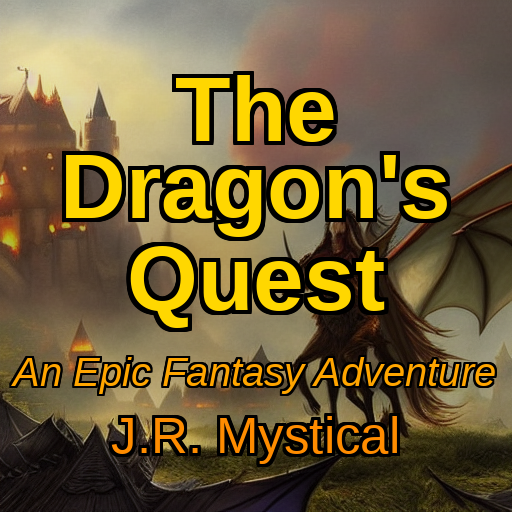

✅ Generated and saved as /content/enhanced_cover_the_dragon's_quest.png
   Layout: center, Colors: gold

Test 2: Generating cover for 'Cyber Dreams'
Generating: a sks book cover illustration of futuristic sci-fi cyberpunk cityscape with neon lights, highly detailed, digital art, artwork, painting, no text, no words, no letters, no title, textless, wordless
Negative prompt: text, words, letters, title, subtitle, author name, typography, writing, captions, labels, watermark, signature


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Base image generated successfully
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
✅ Professional text overlay applied


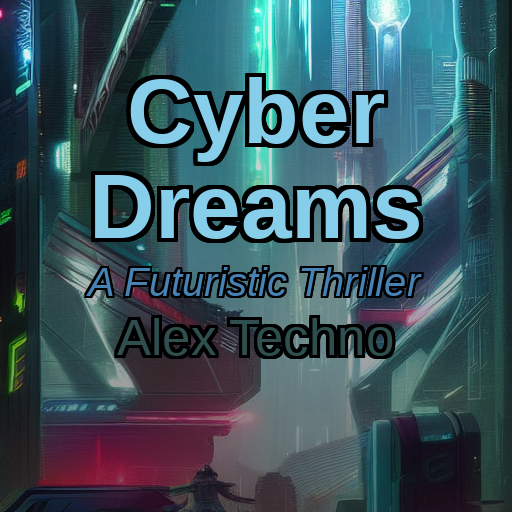

✅ Generated and saved as /content/enhanced_cover_cyber_dreams.png
   Layout: top, Colors: blue

Test 3: Generating cover for 'The Secret Garden'
Generating: a sks book cover illustration of mysterious enchanted garden with flowers and moonlight, highly detailed, digital art, artwork, painting, no text, no words, no letters, no title, textless, wordless
Negative prompt: text, words, letters, title, subtitle, author name, typography, writing, captions, labels, watermark, signature


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Base image generated successfully
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
✅ Professional text overlay applied


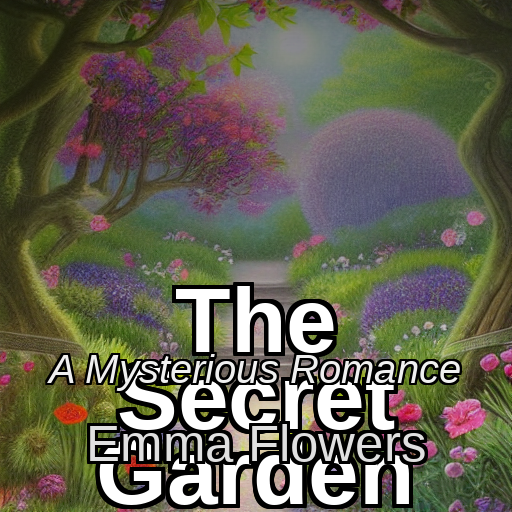

✅ Generated and saved as /content/enhanced_cover_the_secret_garden.png
   Layout: bottom, Colors: white

Test 4: Generating cover for 'Lost in Ancient Ruins'
Generating: a sks book cover illustration of archaeological adventure in ancient temple ruins, highly detailed, digital art, artwork, painting, no text, no words, no letters, no title, textless, wordless
Negative prompt: text, words, letters, title, subtitle, author name, typography, writing, captions, labels, watermark, signature


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Base image generated successfully
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
✅ Professional text overlay applied


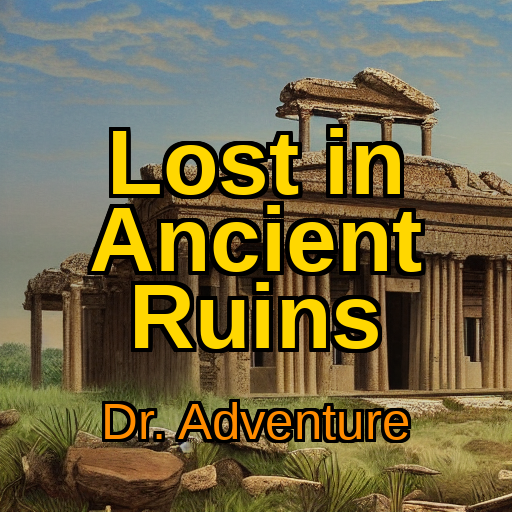

✅ Generated and saved as /content/enhanced_cover_lost_in_ancient_ruins.png
   Layout: center, Colors: gold

Test 5: Generating cover for 'Digital Hearts'
Generating: a sks book cover illustration of contemporary tech world with digital elements and circuits, highly detailed, digital art, artwork, painting, no text, no words, no letters, no title, textless, wordless
Negative prompt: text, words, letters, title, subtitle, author name, typography, writing, captions, labels, watermark, signature


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Base image generated successfully
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
✅ Professional text overlay applied


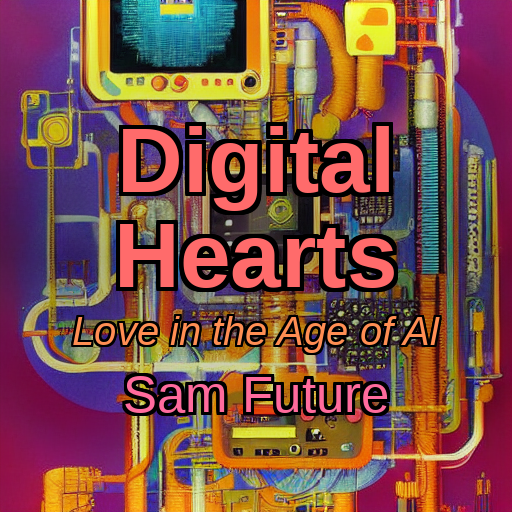

✅ Generated and saved as /content/enhanced_cover_digital_hearts.png
   Layout: center, Colors: red


In [20]:
# =============================================================================
# STEP 9: Enhanced Book Cover Generation (FIXED VERSION)
# =============================================================================
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageEnhance
import os
import numpy as np
import torch
from diffusers import StableDiffusionPipeline

print("Loading trained model for testing...")

# Create pipeline with trained model
pipeline = StableDiffusionPipeline.from_pretrained(
    config.output_dir,
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

class BookCoverDesigner:
    def __init__(self):
        self.font_paths = {
            'title': [
                "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",
                "/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf",
                "/System/Library/Fonts/Arial.ttf",
                "/usr/share/fonts/truetype/ubuntu/Ubuntu-Bold.ttf"
            ],
            'subtitle': [
                "/usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf",
                "/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf",
                "/System/Library/Fonts/Arial.ttf"
            ],
            'author': [
                "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
                "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
                "/System/Library/Fonts/Arial.ttf"
            ]
        }

    # def load_font(self, font_type, size):
    #     """Load the best available font for the given type and size."""
    #     for font_path in self.font_paths[font_type]:
    #         try:
    #             return ImageFont.truetype(font_path, size)
    #         except (OSError, IOError, AttributeError):
    #             continue

    #     # Try to create a basic default font
    #     try:
    #         # Try different ways to get a default font
    #         default_font = ImageFont.load_default()
    #         return default_font
    #     except:
    #         try:
    #             # Alternative approach for default font
    #             return ImageFont.truetype("arial.ttf", size)
    #         except:
    #             # Last resort - create a minimal font object
    #             # This should work in all environments
    #             class MinimalFont:
    #                 def __init__(self, size):
    #                     self.size = size

    #                 def getsize(self, text):
    #                     # Approximate text size
    #                     return (len(text) * self.size // 2, self.size)

    #                 def getbbox(self, text):
    #                     w, h = self.getsize(text)
    #                     return (0, 0, w, h)

    #             return MinimalFont(size)
    def load_font(self, font_type, size):
        """Load the best available font for the given type and size."""

        # Try each font path
        for font_path in self.font_paths[font_type]:
            try:
                # Check if file exists first
                if os.path.exists(font_path):
                    return ImageFont.truetype(font_path, size)
                else:
                    print(f"Font file not found: {font_path}")
                    continue
            except (OSError, IOError, AttributeError) as e:
                print(f"Failed to load font {font_path}: {e}")
                continue

        # If no system fonts work, try fallbacks
        print("No system fonts found, trying fallbacks...")

        # Try basic default font
        try:
            print("Attempting to load default font...")
            default_font = ImageFont.load_default()
            print("✅ Using PIL default font")
            return default_font
        except Exception as e:
            print(f"Default font failed: {e}")

        # Try arial variants
        for arial_name in ["arial.ttf", "Arial.ttf", "ARIAL.TTF"]:
            try:
                font = ImageFont.truetype(arial_name, size)
                print(f"✅ Loaded {arial_name}")
                return font
            except Exception:
                continue

        # Last resort - create minimal font that won't crash
        print(f"Creating minimal font handler for size {size}")

        class MinimalFont:
            def __init__(self, size):
                self.size = size

            def getsize(self, text):
                # Approximate text size
                return (len(text) * max(self.size // 2, 6), self.size)

            def getbbox(self, text):
                w, h = self.getsize(text)
                return (0, 0, w, h)

        return MinimalFont(size)

    def create_text_shadow(self, draw, pos, text, font, text_color, shadow_color="black", shadow_offset=3, shadow_blur=2):
        """Create text with shadow effect - simplified version."""
        x, y = pos

        try:
            # Simple shadow approach - draw multiple offset shadows
            for dx in range(-shadow_offset, shadow_offset + 1):
                for dy in range(-shadow_offset, shadow_offset + 1):
                    if dx != 0 or dy != 0:
                        draw.text((x + dx, y + dy), text, font=font, fill=shadow_color)

            # Draw main text on top
            draw.text(pos, text, font=font, fill=text_color)

        except Exception as e:
            print(f"Shadow rendering error: {e}, falling back to simple text")
            # Fallback - just draw text without shadow
            draw.text(pos, text, font=font, fill=text_color)

    def create_gradient_overlay(self, image, gradient_type="top_to_bottom", opacity=0.4):
        """Create gradient overlay for better text visibility."""
        W, H = image.size
        overlay = Image.new('RGBA', (W, H), (0, 0, 0, 0))

        if gradient_type == "top_to_bottom":
            for y in range(H):
                alpha = int(255 * opacity * (y / H))
                overlay.paste((0, 0, 0, alpha), (0, y, W, y + 1))
        elif gradient_type == "bottom_to_top":
            for y in range(H):
                alpha = int(255 * opacity * ((H - y) / H))
                overlay.paste((0, 0, 0, alpha), (0, y, W, y + 1))
        elif gradient_type == "center_fade":
            center_y = H // 2
            for y in range(H):
                distance = abs(y - center_y) / (H // 2)
                alpha = int(255 * opacity * (1 - distance))
                overlay.paste((0, 0, 0, alpha), (0, y, W, y + 1))

        # Composite with original image
        if image.mode != 'RGBA':
            image = image.convert('RGBA')

        result = Image.alpha_composite(image, overlay)
        return result.convert('RGB')

    def wrap_text(self, text, font, max_width, draw):
        """Wrap text to fit within max_width - with better error handling."""
        words = text.split()
        lines = []
        current_line = ""

        for word in words:
            test_line = current_line + (" " if current_line else "") + word

            try:
                # Try to get text bounding box
                if hasattr(font, 'getbbox'):
                    bbox = font.getbbox(test_line)
                    line_width = bbox[2] - bbox[0]
                elif hasattr(draw, 'textbbox'):
                    bbox = draw.textbbox((0, 0), test_line, font=font)
                    line_width = bbox[2] - bbox[0]
                elif hasattr(font, 'getsize'):
                    line_width, _ = font.getsize(test_line)
                else:
                    # Fallback estimation
                    line_width = len(test_line) * 12  # Rough estimate

            except Exception as e:
                print(f"Text measurement error: {e}, using estimation")
                line_width = len(test_line) * 12  # Rough character width estimation

            if line_width <= max_width:
                current_line = test_line
            else:
                if current_line:
                    lines.append(current_line)
                    current_line = word
                else:
                    # Single word is too long, force break
                    lines.append(word)

        if current_line:
            lines.append(current_line)

        return lines

    def add_professional_text_overlay(self, image, title, subtitle="", author="",
                                    layout="center", color_scheme="white"):
        """Add professional text overlay to book cover."""

        # Convert to RGBA for better text rendering
        if image.mode != 'RGBA':
            image = image.convert('RGBA')

        W, H = image.size

        # Add gradient overlay for better text visibility
        if layout == "top":
            image = self.create_gradient_overlay(image, "top_to_bottom", opacity=0.5)
        elif layout == "bottom":
            image = self.create_gradient_overlay(image, "bottom_to_top", opacity=0.5)
        else:
            image = self.create_gradient_overlay(image, "center_fade", opacity=0.3)

        # Convert back to RGB for drawing
        image = image.convert('RGB')
        draw = ImageDraw.Draw(image)

        # Color schemes
        color_schemes = {
            "white": {"title": "white", "subtitle": "#f0f0f0", "author": "#e0e0e0", "shadow": "black"},
            "gold": {"title": "#FFD700", "subtitle": "#FFA500", "author": "#FF8C00", "shadow": "black"},
            "blue": {"title": "#87CEEB", "subtitle": "#4682B4", "author": "#2F4F4F", "shadow": "black"},
            "red": {"title": "#FF6B6B", "subtitle": "#FF8E53", "author": "#FF6B9D", "shadow": "black"}
        }

        colors = color_schemes.get(color_scheme, color_schemes["white"])

        # Calculate responsive font sizes
        base_size = min(W, H) // 10
        title_size = max(int(base_size * 1.8), 40)
        subtitle_size = max(int(base_size * 0.8), 20)
        author_size = max(int(base_size * 1.0), 24)

        # Load fonts
        title_font = self.load_font('title', title_size)
        subtitle_font = self.load_font('subtitle', subtitle_size)
        author_font = self.load_font('author', author_size)

        # Wrap title text
        max_text_width = int(W * 0.85)
        title_lines = self.wrap_text(title, title_font, max_text_width, draw)

        # Calculate text dimensions with better error handling
        title_height = 0
        title_widths = []
        for line in title_lines:
            try:
                if hasattr(draw, 'textbbox'):
                    bbox = draw.textbbox((0, 0), line, font=title_font)
                    line_height = bbox[3] - bbox[1]
                    line_width = bbox[2] - bbox[0]
                elif hasattr(title_font, 'getsize'):
                    line_width, line_height = title_font.getsize(line)
                else:
                    # Fallback estimation
                    line_width = len(line) * (title_size // 2)
                    line_height = title_size

                title_height += line_height + 10  # Add line spacing
                title_widths.append(line_width)

            except Exception as e:
                print(f"Text measurement error: {e}")
                # Use fallback dimensions
                line_width = len(line) * (title_size // 2)
                line_height = title_size
                title_height += line_height + 10
                title_widths.append(line_width)

        # Similar error handling for subtitle and author
        try:
            if subtitle and hasattr(draw, 'textbbox'):
                subtitle_bbox = draw.textbbox((0, 0), subtitle, font=subtitle_font)
                subtitle_height = subtitle_bbox[3] - subtitle_bbox[1]
                subtitle_width = subtitle_bbox[2] - subtitle_bbox[0]
            elif subtitle and hasattr(subtitle_font, 'getsize'):
                subtitle_width, subtitle_height = subtitle_font.getsize(subtitle)
            else:
                subtitle_height = subtitle_size if subtitle else 0
                subtitle_width = len(subtitle) * (subtitle_size // 2) if subtitle else 0
        except:
            subtitle_height = subtitle_size if subtitle else 0
            subtitle_width = len(subtitle) * (subtitle_size // 2) if subtitle else 0

        try:
            if author and hasattr(draw, 'textbbox'):
                author_bbox = draw.textbbox((0, 0), author, font=author_font)
                author_height = author_bbox[3] - author_bbox[1]
                author_width = author_bbox[2] - author_bbox[0]
            elif author and hasattr(author_font, 'getsize'):
                author_width, author_height = author_font.getsize(author)
            else:
                author_height = author_size if author else 0
                author_width = len(author) * (author_size // 2) if author else 0
        except:
            author_height = author_size if author else 0
            author_width = len(author) * (author_size // 2) if author else 0

        # Calculate positions based on layout
        if layout == "top":
            title_y = 60
            subtitle_y = title_y + title_height + 30
            author_y = subtitle_y + subtitle_height + 20
        elif layout == "bottom":
            author_y = H - author_height - 60
            subtitle_y = author_y - author_height - 30 if author else H - subtitle_height - 60
            title_y = subtitle_y - subtitle_height - 40 if subtitle else author_y - title_height - 60
        else:  # center
            total_height = title_height + (30 if subtitle else 0) + subtitle_height + (20 if author else 0) + author_height
            start_y = (H - total_height) // 2
            title_y = start_y
            subtitle_y = title_y + title_height + 30
            author_y = subtitle_y + subtitle_height + 20

        # Draw title (multiple lines) with error handling
        current_y = title_y
        for i, line in enumerate(title_lines):
            try:
                line_width = title_widths[i] if i < len(title_widths) else len(line) * (title_size // 2)
                x = (W - line_width) // 2

                # Create enhanced shadow effect
                self.create_text_shadow(draw, (x, current_y), line, title_font,
                                      colors["title"], colors["shadow"],
                                      shadow_offset=4, shadow_blur=3)

                # Calculate line height for next line
                try:
                    if hasattr(draw, 'textbbox'):
                        bbox = draw.textbbox((0, 0), line, font=title_font)
                        line_height = bbox[3] - bbox[1]
                    elif hasattr(title_font, 'getsize'):
                        _, line_height = title_font.getsize(line)
                    else:
                        line_height = title_size
                except:
                    line_height = title_size

                current_y += line_height + 10

            except Exception as e:
                print(f"Error drawing title line {i}: {e}")
                continue

        # Draw subtitle
        if subtitle:
            x = (W - subtitle_width) // 2
            self.create_text_shadow(draw, (x, subtitle_y), subtitle, subtitle_font,
                                  colors["subtitle"], colors["shadow"],
                                  shadow_offset=2, shadow_blur=2)

        # Draw author
        if author:
            x = (W - author_width) // 2
            self.create_text_shadow(draw, (x, author_y), author, author_font,
                                  colors["author"], colors["shadow"],
                                  shadow_offset=3, shadow_blur=2)

        return image

# Create the designer instance
designer = BookCoverDesigner()

def simple_text_overlay_fallback(image, title, subtitle="", author=""):
    """Simple fallback text overlay if main function fails."""
    try:
        draw = ImageDraw.Draw(image)
        W, H = image.size

        # Use basic default font
        font_size = max(W // 15, 20)
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except:
            font = ImageFont.load_default()

        # Simple text positioning
        y_pos = H // 3

        # Draw title with simple outline
        title_lines = [title[i:i+20] for i in range(0, len(title), 20)]  # Simple line breaking

        for i, line in enumerate(title_lines):
            text_width = len(line) * (font_size // 2)  # Rough estimate
            x = (W - text_width) // 2
            y = y_pos + i * (font_size + 10)

            # Draw outline
            for dx in [-2, -1, 0, 1, 2]:
                for dy in [-2, -1, 0, 1, 2]:
                    if dx != 0 or dy != 0:
                        draw.text((x + dx, y + dy), line, font=font, fill="black")

            # Draw main text
            draw.text((x, y), line, font=font, fill="white")

        # Draw author at bottom if provided
        if author:
            author_y = H - font_size - 20
            author_width = len(author) * (font_size // 3)
            author_x = (W - author_width) // 2

            # Outline
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx != 0 or dy != 0:
                        draw.text((author_x + dx, author_y + dy), author, font=font, fill="black")

            draw.text((author_x, author_y), author, font=font, fill="white")

        return image
    except Exception as e:
        print(f"Even fallback text overlay failed: {e}")
        return image

# Modified main generation function with fallback
def generate_book_cover_enhanced(title, plot, author="", subtitle="",
                               layout="center", color_scheme="white",
                               num_inference_steps=50, guidance_scale=7.5):
    """Generate enhanced book cover with professional text overlay."""

    # CRITICAL: Remove ALL text-related words from the prompt
    clean_prompt = f"a sks book cover illustration of {plot}, highly detailed, digital art, artwork, painting, no text, no words, no letters, no title, textless, wordless"

    # Add negative prompt to really prevent text generation
    negative_prompt = "text, words, letters, title, subtitle, author name, typography, writing, captions, labels, watermark, signature"

    print(f"Generating: {clean_prompt}")
    print(f"Negative prompt: {negative_prompt}")

    try:
        # Generate base image WITHOUT text
        image = pipeline(
            clean_prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            height=config.resolution,
            width=config.resolution
        ).images[0]

        print("✅ Base image generated successfully")

        # Try professional text overlay first
        try:
            enhanced_image = designer.add_professional_text_overlay(
                image, title, subtitle, author, layout, color_scheme
            )
            print("✅ Professional text overlay applied")
            return enhanced_image

        except Exception as overlay_error:
            print(f"⚠️  Professional overlay failed: {overlay_error}")
            print("🔄 Trying simple fallback overlay...")

            # Use simple fallback
            fallback_image = simple_text_overlay_fallback(image, title, subtitle, author)
            print("✅ Simple fallback overlay applied")
            return fallback_image

    except Exception as e:
        print(f"❌ Error in generation: {e}")
        return None

# Enhanced test examples with more details
test_examples = [
    {
        "title": "The Dragon's Quest",
        "subtitle": "An Epic Fantasy Adventure",
        "author": "J.R. Mystical",
        "plot": "epic fantasy adventure through magical realms with dragons and castles",
        "layout": "center",
        "color_scheme": "gold"
    },
    {
        "title": "Cyber Dreams",
        "subtitle": "A Futuristic Thriller",
        "author": "Alex Techno",
        "plot": "futuristic sci-fi cyberpunk cityscape with neon lights",
        "layout": "top",
        "color_scheme": "blue"
    },
    {
        "title": "The Secret Garden",
        "subtitle": "A Mysterious Romance",
        "author": "Emma Flowers",
        "plot": "mysterious enchanted garden with flowers and moonlight",
        "layout": "bottom",
        "color_scheme": "white"
    },
    {
        "title": "Lost in Ancient Ruins",
        "subtitle": "",
        "author": "Dr. Adventure",
        "plot": "archaeological adventure in ancient temple ruins",
        "layout": "center",
        "color_scheme": "gold"
    },
    {
        "title": "Digital Hearts",
        "subtitle": "Love in the Age of AI",
        "author": "Sam Future",
        "plot": "contemporary tech world with digital elements and circuits",
        "layout": "center",
        "color_scheme": "red"
    }
]

print("\n" + "="*60)
print("TESTING ENHANCED BOOK COVER GENERATION")
print("="*60)

for i, example in enumerate(test_examples):
    title = example["title"]
    print(f"\nTest {i+1}: Generating cover for '{title}'")

    try:
        image = generate_book_cover_enhanced(
            title=example["title"],
            plot=example["plot"],
            author=example["author"],
            subtitle=example["subtitle"],
            layout=example["layout"],
            color_scheme=example["color_scheme"]
        )

        if image:
            display(image)

            # Save image
            filename = f"enhanced_cover_{title.replace(' ', '_').lower()}.png"
            filepath = f"/content/{filename}"
            image.save(filepath)
            print(f"✅ Generated and saved as {filepath}")
            print(f"   Layout: {example['layout']}, Colors: {example['color_scheme']}")
        else:
            print(f"❌ Failed to generate cover for '{title}'")

    except Exception as e:
        print(f"❌ Error generating cover for '{title}': {e}")
        import traceback
        traceback.print_exc()



INTERACTIVE ENHANCED BOOK COVER GENERATOR
Your DreamBooth model is ready!
Enter book details to generate custom covers.
Type 'quit' at any prompt to exit.

----------------------------------------
 Book Title: My Girl
 Subtitle (optional): Mom Loves Me
 Author Name: Jessica
 Plot Summary: Mother in serach of her lost daughter
 Layout (center/top/bottom) [default: center]: top
 Color Scheme (white/gold/blue/red) [default: white]: 

🎨 Generating enhanced cover for 'My Girl'...
Generating: a sks book cover illustration of Mother in serach of her lost daughter, highly detailed, digital art, artwork, painting, no text, no words, no letters, no title, textless, wordless
Negative prompt: text, words, letters, title, subtitle, author name, typography, writing, captions, labels, watermark, signature


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Base image generated successfully
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
✅ Professional text overlay applied


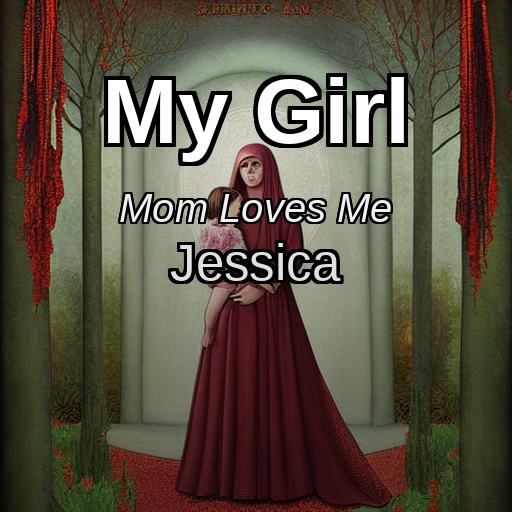

✅ Cover generated and saved as /content/custom_enhanced_my_girl.png
   Layout: top, Colors: white
   Check your output directory to download your image!

 Generate another cover? (y/n) [default: y]: quit
----------------------------------------
 Book Title: Farewell
 Subtitle (optional): 
 Author Name: rena
 Plot Summary: A mysterious farewell party 
 Layout (center/top/bottom) [default: center]: 
 Color Scheme (white/gold/blue/red) [default: white]: 

🎨 Generating enhanced cover for 'Farewell'...
Generating: a sks book cover illustration of A mysterious farewell party, highly detailed, digital art, artwork, painting, no text, no words, no letters, no title, textless, wordless
Negative prompt: text, words, letters, title, subtitle, author name, typography, writing, captions, labels, watermark, signature


  0%|          | 0/50 [00:00<?, ?it/s]

✅ Base image generated successfully
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf
Font file not found: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
✅ Professional text overlay applied


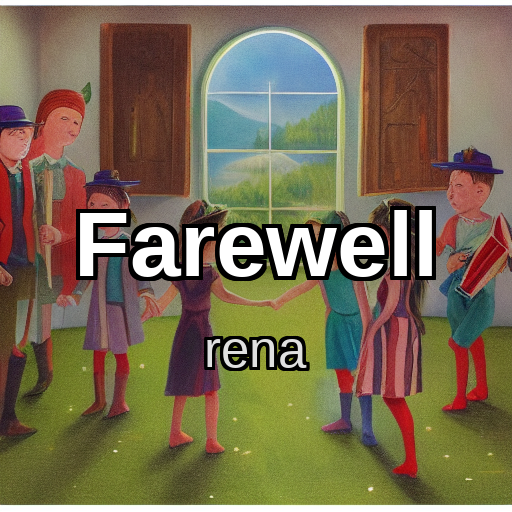

✅ Cover generated and saved as /content/custom_enhanced_farewell.png
   Layout: center, Colors: white
   Check your output directory to download your image!

 Generate another cover? (y/n) [default: y]: n

SESSION COMPLETE


In [21]:
# =============================================================================
# STEP 10: Interactive Enhanced Book Cover Generator
# =============================================================================

def interactive_book_cover_generator_enhanced():
    """Interactive interface for generating book covers with professional styling"""

    print("\n" + "="*60)
    print("INTERACTIVE ENHANCED BOOK COVER GENERATOR")
    print("="*60)
    print("Your DreamBooth model is ready!")
    print("Enter book details to generate custom covers.")
    print("Type 'quit' at any prompt to exit.\n")

    while True:
        try:
            print("-" * 40)
            title = input(" Book Title: ").strip()
            if title.lower() == 'quit':
                break

            subtitle = input(" Subtitle (optional): ").strip()
            if subtitle.lower() == 'quit':
                break

            author = input(" Author Name: ").strip()
            if author.lower() == 'quit':
                break

            plot = input(" Plot Summary: ").strip()
            if plot.lower() == 'quit':
                break

            layout = input(" Layout (center/top/bottom) [default: center]: ").strip().lower()
            if layout.lower() == 'quit':
                break
            if layout not in ["center", "top", "bottom"]:
                layout = "center"

            color_scheme = input(" Color Scheme (white/gold/blue/red) [default: white]: ").strip().lower()
            if color_scheme.lower() == 'quit':
                break
            if color_scheme not in ["white", "gold", "blue", "red"]:
                color_scheme = "white"

            if not title or not plot:
                print("  Please provide at least a title and plot summary!")
                continue

            print(f"\n Generating enhanced cover for '{title}'...")

            # Generate image using ENHANCED generator
            image = generate_book_cover_enhanced(
                title=title,
                plot=plot,
                author=author,
                subtitle=subtitle,
                layout=layout,
                color_scheme=color_scheme
            )

            if image:
                display(image)

                # Create safe filename
                safe_title = "".join(c for c in title if c.isalnum() or c in (' ', '-', '_')).rstrip()
                filename = f"custom_enhanced_{safe_title.replace(' ', '_').lower()}.png"
                filepath = f"/content/{filename}"

                image.save(filepath)
                print(f" Cover generated and saved as {filepath}")
                print(f"   Layout: {layout}, Colors: {color_scheme}")
                print("   Check your output directory to download your image!\n")

                # Ask if user wants to generate another
                another = input(" Generate another cover? (y/n) [default: y]: ").strip().lower()
                if another in ['n', 'no']:
                    break

            else:
                print(" Failed to generate cover. Try again with different parameters.\n")

        except KeyboardInterrupt:
            print("\n\n Exiting interactive generator. Thanks for using the book cover generator!")
            break
        except Exception as e:
            print(f" Error: {e}")
            print("Please try again with different inputs.\n")
            import traceback
            traceback.print_exc()

    print("\n" + "="*60)
    print("SESSION COMPLETE")
    print("="*60)

# Run interactive enhanced generator
interactive_book_cover_generator_enhanced()

In [22]:
# =============================================================================
# STEP 11: Download Trained Model
# =============================================================================
import shutil
import os

# Create zip package of trained model
shutil.make_archive('/content/dreambooth_model', 'zip', config.output_dir)

print(" Model packaged as: dreambooth_model.zip")


# Also create a tar.gz version (sometimes preferred for deployment)
shutil.make_archive('/content/dreambooth_model', 'gztar', config.output_dir)




 Model packaged as: dreambooth_model.zip


'/content/dreambooth_model.tar.gz'

In [28]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy the model zip to your Drive
shutil.copy('/content/dreambooth_model.zip', '/content/drive/MyDrive/dreambooth_model.zip')
print("Copied to Google Drive. You can download it from there.")


Mounted at /content/drive
Copied to Google Drive. You can download it from there.
